In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math
import numpy as np 

class TSP():
    cities = 0
    distances = []
    locations = []
    
    def distance(self, c1, c2):
        loc1, loc2 = self.locations[c1], self.locations[c2]
        return math.sqrt((loc1[0]-loc2[0])**2 + (loc1[1]-loc2[1])**2)
    
    def __init__(self, cities, seed=1):
        random.seed(seed)
        self.cities = cities
        
        self.locations = []
        for i in range(cities):
            self.locations.append((random.random(), random.random()))
        
        self.distances = []
        for i in range(cities):
            self.distances.append([])
            for j in range(cities):
                self.distances[i].append(self.distance(i, j))
                
    def random_solution(self):
        s = [i for i in range(self.cities)]
        random.shuffle(s)
        return s
    
    def evaluate(self, s):
        fit = 0
        for i in range(len(s)):
            fit += self.distances[s[i]][s[i+1 if i+1<len(s) else 0]]
        return fit
    
    def mutate(self, s):
        sol = s[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        rev = sol[c1:c2+1]
        rev.reverse()
        sol[c1:c2+1] = rev
        return sol
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        sol1[c1:c2+1] = list(filter(lambda x: x in sol1[c1:c2+1], s2))
        sol2[c1:c2+1] = list(filter(lambda x: x in sol2[c1:c2+1], s1))
        
        return sol1, sol2
    
    def display_solution_param(self, solution):
        fig, ax = plt.subplots(figsize=(8, 8))

        x = [i[1] for i in [self.locations[c] for c in solution]]
        y = [i[0] for i in [self.locations[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)
            
        plt.xlim((-0.03,1.03))
        plt.ylim((-0.03,1.03))
        plt.show()

**Task 1:** Implement the generational evolutionary algorithm with tournament selection. Let it be parametrized with four parameters: the size of the population $N$, the size of the tournament $t$, the probability of mutation $p_m$ and the probability of crossover $p_c$. The algorithm should terminate automatically after 50 generations with no improvement.

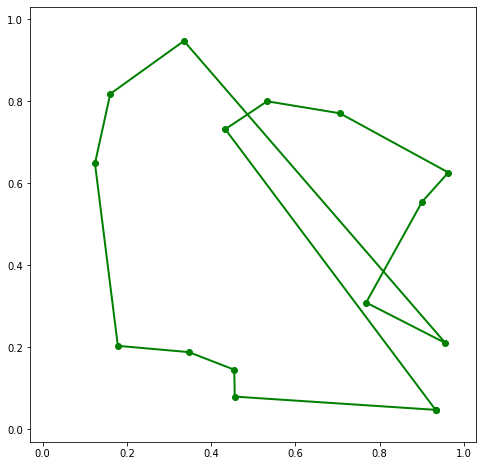

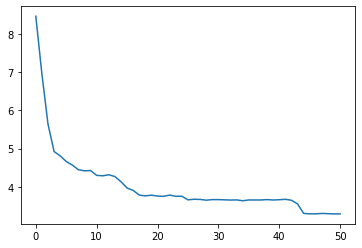

In [172]:
N = 250 # population size
t = 10 # size of tournament
p_m = 0.05 # prob of mutation
p_c = 0.05 # prob of crossover
population = []
population_eval = []
tsp = TSP(15, seed=100) 

def tournament(population, population_eval, tourment_size):
    random_solutions = np.random.permutation(len(population))[:tourment_size]
    random_solutions.sort()
    best_solution_arg = np.argmin(population_eval[random_solutions])
#     print(random_solutions, best_solution_arg, np.max(population_eval[random_solutions]), np.min(population_eval[random_solutions]), population_eval[random_solutions])
    return random_solutions[best_solution_arg] # index of best solution 

for n in range(N):
    sol = tsp.random_solution()
    population.append(sol)
    population_eval.append(tsp.evaluate(sol))

population_eval = np.array(population_eval)
# print(population_eval)
avg_eval = [np.average(population_eval)]

for i in range(50):
    new_population = []
    new_population_eval = []
    while len(new_population_eval) < N:
        if random.random() < p_c:
            new_solution_1 = population[tournament(population, population_eval, t)]
            new_solution_2 = population[tournament(population, population_eval, t)]
            new_solution_1, new_solution_2 = tsp.crossover(new_solution_1, new_solution_2)
            if random.random() < p_m:
                new_solution_1 = tsp.mutate(new_solution_1)
            new_population.append(new_solution_1)
            new_population_eval.append(tsp.evaluate(new_solution_1))
            
            if len(new_population_eval) >= N:
                break
            
            if random.random() < p_m:
                new_solution_2 = tsp.mutate(new_solution_2)
            new_population.append(new_solution_2)
            new_population_eval.append(tsp.evaluate(new_solution_2))
            
        else: 
            new_solution = population[tournament(population, population_eval, t)]
            if random.random() < p_m:
                new_solution = tsp.mutate(new_solution)
            new_population.append(new_solution)
            new_population_eval.append(tsp.evaluate(new_solution))
    population = new_population
    population_eval = np.array(new_population_eval)
    avg_eval.append(np.average(population_eval))


arg = np.argmax(population_eval)
tsp.display_solution_param(population[arg])
plt.plot(avg_eval)

In [127]:
random.random()

0.33866914489505884

**Task 2:**

* What is the role of a mutation operator in evolutionary algorithms?
* What are the properties of a good mutation operator?
* What is the role of a crossover operator in evolutionary algorithms?
* What are the properties of a good crossover operator?
* What is the role of a cloning operator in evolutionary algorithms?
* What are the properties of a good genetic representation?
* How can you tell that the population has converged?
* How do the parameters of the evolutionary algorithm affect the speed of its convergence?
* Does the speed of the algorithm's convergence correlate with the quality of the solutions? What is the reason?
* Can a population escape from a local optimum once it has converged?


* What are the strengths of the evolutionary algorithms?
* What are the weaknesses of the evolutionary algorithms?
* What changes would you introduce to the evolutionary algorithms?
* Which problems are evolutionary algorithms best suited for?

**Task 3:** Implement the QAP (https://en.wikipedia.org/wiki/Quadratic_assignment_problem). Use EA to solve it.

In [24]:
class QAP():
    
    def __init__(self, seed=1):
        random.seed(seed)
        #TODO
                
    def random_solution(self):
        s = []
        #TODO
        
        return s
    
    def evaluate(self, s):
        fit = 0
        #TODO
        
        return fit
    
    def mutate(self, s):
        sol = s[:]
        #TODO
        
        return sol
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        #TODO
        
        return sol1, sol2

**Task 4:** Choose one of the problems (TSP or QAP). Assume a constant number of fitness evaluations per each evolutionary run. For a sufficiently big (nontrivial) problem:

a) Assume $N = 200$, $t = 5$. Prepare a heatmap illustrating the influence of values of $p_m$ and $p_c$ on the quality of the solution.

b) Assume $p_m = 0.5$, $p_c = 0.5$. Prepare a heatmap illustrating the influence of values of $N$ and $t$ on the quality of the solution.

Discuss the results. Can we expect to see similar results under different search termination conditions (e.g. a number of iterations with no improvement)? Can we expect to see similar results for different optimization problems?